# Random Fourier features on a Duffing oscillator

This example shows how random Fourier features (and randomly binned features) can be used as lifting functions to identify Duffing oscillator dynamics.

In [1]:
# Imports
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

import pykoop

# Set plot defaults
plt.rc('lines', linewidth=2)
plt.rc('axes', grid=True)
plt.rc('grid', linestyle='--')

Load example data from the library. `eg` is a `dict` containing training data, validation data, and a few related parameters.

In [2]:
eg = pykoop.example_data_duffing()

Create a Koopman pipeline with 100 random Fourier features (approximating a Gaussian kernel by default).

In [3]:
# Create RFF pipeline
kp_rff = pykoop.KoopmanPipeline(
    lifting_functions=[(
        'rff',
        pykoop.KernelApproxLiftingFn(
            kernel_approx=pykoop.RandomFourierKernelApprox(
                n_components=100,
                random_state=1234,
            )),
    )],
    regressor=pykoop.Edmd(),
)

Create a Koopman pipeline with randomly binned features (approximating a Laplacian kernel). This will result in around 150 one-hot encoded features generated from a binning procedure.

In [4]:
# Create random binning pipeline for comparison
kp_bin = pykoop.KoopmanPipeline(
    lifting_functions=[(
        'bin',
        pykoop.KernelApproxLiftingFn(
            kernel_approx=pykoop.RandomBinningKernelApprox(
                n_components=10,
                random_state=1234,
            )),
    )],
    regressor=pykoop.Edmd(),
)

For each pipeline, predict the outputs and plot the results.

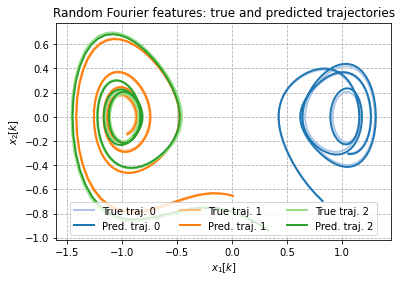

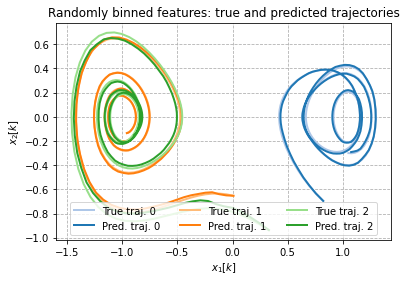

In [5]:
for label, kp in [
    ('Random Fourier features', kp_rff),
    ('Randomly binned features', kp_bin),
]:
    # Fit the pipeline
    kp.fit(
        eg['X_train'],
        n_inputs=eg['n_inputs'],
        episode_feature=eg['episode_feature'],
    )

    # Get training and validation episodes
    ep_train = np.unique(eg['X_train'][:, 0])
    ep_valid = np.unique(eg['X_valid'][:, 0])

    # Predict new trajectories
    X_pred = kp.predict_trajectory(
        eg['x0_valid'],
        eg['u_valid'],
    )

    # Plot validation trajectories
    fig, ax = plt.subplots()
    tab20 = plt.cm.tab20(np.arange(0, 1, 0.05))
    color = [
        (tab20[1], tab20[0]),
        (tab20[3], tab20[2]),
        (tab20[5], tab20[4]),
    ]
    for (i, ep) in enumerate(ep_valid):
        idx = eg['X_valid'][:, 0] == ep
        cax_valid = ax.plot(
            eg['X_valid'][idx, 1],
            eg['X_valid'][idx, 2],
            color=color[i][0],
            label=f'True traj. {i}',
        )
        cax_pred = ax.plot(
            X_pred[idx, 1],
            X_pred[idx, 2],
            label=f'Pred. traj. {i}',
        )
    # Set legend
    ax.legend(loc='lower center', ncol=3)
    # Set labels
    ax.set_title(f'{label}: true and predicted trajectories')
    ax.set_xlabel('$x_1[k]$')
    ax.set_ylabel('$x_2[k]$')